KERAS / TF

In [1]:
import nibabel as nib
import numpy as np

In [2]:
def load_resample(subj ):

    input_data, [lx,lX,ly,lY,lz,lZ,rx,rX,ry,rY,rz,rZ] = pad(subj, 128)
    in_max = np.percentile(input_data[np.nonzero(input_data)], 99.99)
    input_data = normalize_img(input_data, in_max, 0, 1, 0)
    input_data = np.squeeze(input_data)
    input_vols = np.zeros(( 1, 128, 128, 128,1))
    input_vols[0,:,:,:,0] = input_data

    return tf.convert_to_tensor(input_vols, dtype=tf.float32), lx,lX,ly,lY,lz,lZ,rx,rX,ry,rY,rz,rZ, in_max

def pad(img, sz):

    tmp = np.zeros((sz, sz, sz))

    diff = int((sz-img.shape[0])/2)
    lx = max(diff,0)
    lX = min(img.shape[0]+diff,sz)

    diff = (img.shape[0]-sz) / 2
    rx = max(int(np.floor(diff)),0)
    rX = min(img.shape[0]-int(np.ceil(diff)),img.shape[0])

    diff = int((sz - img.shape[1]) / 2)
    ly = max(diff, 0)
    lY = min(img.shape[1] + diff, sz)

    diff = (img.shape[1] - sz) / 2
    ry = max(int(np.floor(diff)), 0)
    rY = min(img.shape[1] - int(np.ceil(diff)), img.shape[1])

    diff = int((sz - img.shape[2]) / 2)
    lz = max(diff, 0)
    lZ = min(img.shape[2] + diff, sz)

    diff = (img.shape[2] - sz) / 2
    rz = max(int(np.floor(diff)), 0)
    rZ = min(img.shape[2] - int(np.ceil(diff)), img.shape[2])

    tmp[lx:lX,ly:lY,lz:lZ] = img[rx:rX,ry:rY,rz:rZ]
    
    return tmp, [lx,lX,ly,lY,lz,lZ,rx,rX,ry,rY,rz,rZ]

def normalize_img(img, max_img, min_img, a_max, a_min):

    img = (img - min_img)/(max_img - min_img)
    img = np.clip(img, a_max=a_max, a_min=a_min)

    return img

In [3]:
import logging
from scipy.ndimage import gaussian_filter
from dipy.nn.utils import transform_img, recover_img

from dipy.data import get_fnames
from dipy.testing.decorators import doctest_skip_parser
from dipy.utils.optpkg import optional_package
from dipy.nn.utils import set_logger_level

tf, have_tf, _ = optional_package('tensorflow')#, min_version='2.0.0')
tfa, have_tfa, _ = optional_package('tensorflow_addons')
if have_tf and have_tfa:
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import MaxPool3D, Conv3DTranspose
    from tensorflow.keras.layers import Conv3D, LeakyReLU
    from tensorflow.keras.layers import Concatenate, Layer
    from tensorflow_addons.layers import InstanceNormalization
else:
    logging.warning('This model requires Tensorflow.\
                    Please install these packages using \
                    pip. If using mac, please refer to this \
                    link for installation. \
                    https://github.com/apple/tensorflow_macos')


logging.basicConfig()
logger = logging.getLogger('histo_resdnn')


class EncoderBlock(Layer):
    def __init__(self, out_channels, kernel_size, strides, padding):
        super(EncoderBlock, self).__init__()
        self.conv3d = Conv3D(out_channels,
                             kernel_size,
                             strides=strides,
                             padding=padding,
                             use_bias=False)
        self.instnorm = InstanceNormalization(axis=-1, center=False, scale=False)
        self.activation = LeakyReLU(0.01)

    def call(self, input):
        x = self.conv3d(input)
        x = self.instnorm(x)
        x = self.activation(x)

        return x

class DecoderBlock(Layer):
    def __init__(self, out_channels, kernel_size, strides, padding):
        super(DecoderBlock, self).__init__()
        self.conv3d = Conv3DTranspose(out_channels,
                                      kernel_size,
                                      strides=strides,
                                      padding=padding,
                                      use_bias=False)
        self.instnorm = InstanceNormalization(axis=-1, center=False, scale=False)
        self.activation = LeakyReLU(0.01)

    def call(self, input):
        x = self.conv3d(input)
        x = self.instnorm(x)
        x = self.activation(x)

        return x

def UNet3D(input_shape):
    inputs = tf.keras.Input(input_shape)
    # Encode
    x = EncoderBlock(32, kernel_size=3,
                     strides=1, padding='same')(inputs)
    syn0 = EncoderBlock(64, kernel_size=3,
                        strides=1, padding='same')(x)

    x = MaxPool3D()(syn0)
    x = EncoderBlock(64, kernel_size=3,
                     strides=1, padding='same')(x)
    syn1 = EncoderBlock(128, kernel_size=3,
                        strides=1, padding='same')(x)

    x = MaxPool3D()(syn1)
    x = EncoderBlock(128, kernel_size=3,
                     strides=1, padding='same')(x)
    syn2 = EncoderBlock(256, kernel_size=3,
                        strides=1, padding='same')(x)

    x = MaxPool3D()(syn2)
    x = EncoderBlock(256, kernel_size=3,
                     strides=1, padding='same')(x)
    x = EncoderBlock(512, kernel_size=3,
                     strides=1, padding='same')(x)

    # Last layer without relu
    x = Conv3D(512, kernel_size=1,
               strides=1, padding='same')(x)

    x = DecoderBlock(512, kernel_size=2,
                     strides=2, padding='valid')(x)

    x = Concatenate()([x, syn2])

    x = DecoderBlock(256, kernel_size=3,
                     strides=1, padding='same')(x)
    x = DecoderBlock(256, kernel_size=3,
                     strides=1, padding='same')(x)
    x = DecoderBlock(256, kernel_size=2,
                     strides=2, padding='valid')(x)

    x = Concatenate()([x, syn1])

    x = DecoderBlock(128, kernel_size=3,
                     strides=1, padding='same')(x)
    x = DecoderBlock(128, kernel_size=3,
                     strides=1, padding='same')(x)
    x = DecoderBlock(128, kernel_size=2,
                     strides=2, padding='valid')(x)

    x = Concatenate()([x, syn0])

    x = DecoderBlock(64, kernel_size=3,
                     strides=1, padding='same')(x)
    x = DecoderBlock(64, kernel_size=3,
                     strides=1, padding='same')(x)

    x = DecoderBlock(1, kernel_size=1,
                     strides=1, padding='valid')(x)

    # Last layer without relu
    out = Conv3DTranspose(1, kernel_size=1,
                          strides=1, padding='valid')(x)

    return Model(inputs, out)

/home-nfs2/local/VANDERBILT/kanakap/py38-venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-16 09:56:56.258381: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-16 09:56:56.260112: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-16 09:56:56.292345: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-16 09:56:56.293240: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in p

In [4]:
"Run the model inference with h5 weights"
input_file = '/nfs/masi/kanakap/projects/DeepN4/data/IXI015-HH-1258-T1.nii.gz'
img = nib.load(input_file).get_fdata()
img_affine = nib.load(input_file).affine
img_header = nib.load(input_file).header

model = UNet3D(input_shape=(128, 128, 128, 1))

resampled_T1, affine2 = transform_img(img,img_affine)
in_features, lx,lX,ly,lY,lz,lZ,rx,rX,ry,rY,rz,rZ, in_max = load_resample(resampled_T1)
model.load_weights('/nfs/masi/kanakap/projects/DeepN4/src/trained_model_tf/model_weights5.h5')


logfield = model.predict(in_features)
field = np.exp(logfield)
field = field.squeeze()

final_field = np.zeros([resampled_T1.shape[0], resampled_T1.shape[1], resampled_T1.shape[2]])
final_field[rx:rX,ry:rY,rz:rZ] = field[lx:lX,ly:lY,lz:lZ]
final_fields = gaussian_filter(final_field, sigma=3)
upsample_final_field = recover_img(final_fields, affine2, img.shape)


with np.errstate(divide='ignore', invalid='ignore'):
        final_corrected = np.where(upsample_final_field != 0, img / upsample_final_field, 0)

nii = nib.Nifti1Image(final_corrected, affine=img_affine, header=img_header)
nib.save(nii, '/nfs/masi/kanakap/projects/DeepN4/data/dipy_img_corrected_IXI015-HH-1258-T1.nii.gz')  

2024-02-16 09:57:02.478213: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1/1 [==============================] - 5s 5s/step


/tmp/ipykernel_65007/3842347422.py:15: RuntimeWarning: overflow encountered in exp
  field = np.exp(logfield)


In [7]:
THRESHOLD = 1.0
below_threshold_mask = (np.abs(upsample_final_field) < THRESHOLD)
with np.errstate(divide='ignore', invalid='ignore'):
        final_corrected = np.where(below_threshold_mask, 0, img / upsample_final_field)

In [34]:
nii = nib.Nifti1Image(final_corrected, affine=img_affine, header=img_header)
nib.save(nii, '/nfs/masi/kanakap/projects/DeepN4/data/dipy_img_corrected_IXI015-HH-1258-T1.nii.gz')

In [93]:
np.exp(np.squeeze(logfield))

numpy.ndarray

In [22]:
np.shape(input_vols)

(1, 128, 128, 128, 1)

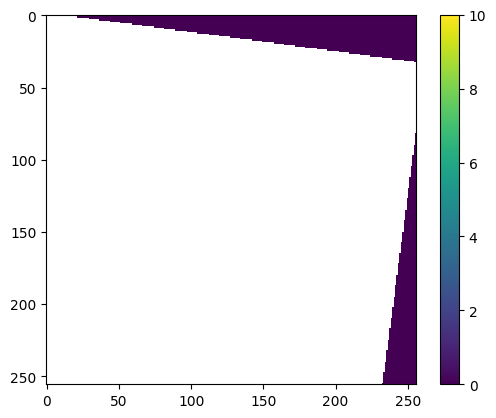

In [13]:
import matplotlib.pyplot as plt
plt.imshow(np.squeeze(final_corrected)[:,:,80] , vmin=0, vmax=10)
plt.colorbar()